In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix,roc_curve, auc

In [5]:
price_data = pd.read_csv('../data/price_1.csv')

X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_Cols,Y_Cols, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the testing set
predictions = rf_regressor.predict(X_test)
print(predictions)
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


[-0.2   0.82 -0.28 ... -1.   -0.06 -0.48]
Mean Squared Error: 0.7463225548902196


In [8]:

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Determine "up days" and "down days"
up_days = np.sum((predictions[1:] - predictions[:-1]) > 0)
down_days = np.sum((predictions[1:] - predictions[:-1]) < 0)

# Calculate accuracy: proportion of days where the direction is predicted correctly
actual_directions = np.sign(y_test.values[1:] - y_test.values[:-1])
predicted_directions = np.sign(predictions[1:] - predictions[:-1])
accuracy = np.mean(actual_directions == predicted_directions)

# Print the regression report
print("Regression Report:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print(f"Number of Up Days: {up_days}")
print(f"Number of Down Days: {down_days}")
print(f"Accuracy: {accuracy * 100:.2f}%")


Regression Report:
Mean Squared Error: 0.7463225548902196
Mean Absolute Error: 0.6991616766467066
R-squared: 0.2518144406812155
Number of Up Days: 487
Number of Down Days: 500
Accuracy: 40.86%


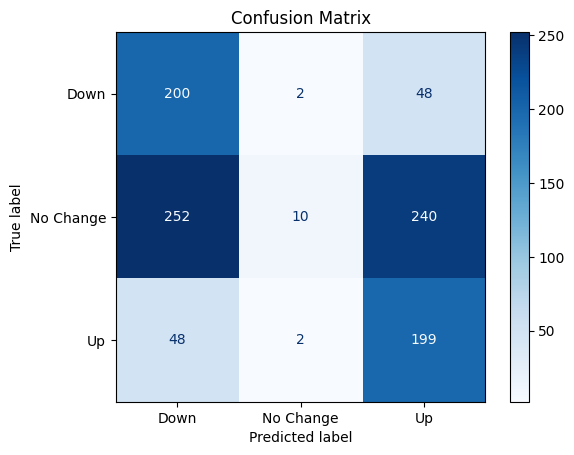

In [17]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Determine actual and predicted directions
actual_directions = np.sign(y_test.values[1:] - y_test.values[:-1])
predicted_directions = np.sign(predictions[1:] - predictions[:-1])

# Ensure labels are -1, 0, 1 (for down, no change, up)
actual_directions = np.where(actual_directions > 0, 1, np.where(actual_directions < 0, -1, 0))
predicted_directions = np.where(predicted_directions > 0, 1, np.where(predicted_directions < 0, -1, 0))

# Calculate accuracy
accuracy = accuracy_score(actual_directions, predicted_directions)

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_directions, predicted_directions, labels=[-1, 0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'No Change', 'Up'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [18]:
feature_imp = pd.Series(rf_regressor.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp


r_percent               0.237811
RSI                     0.179912
MACD                    0.168096
Price_Rate_Of_Change    0.166643
On Balance Volume       0.135685
k_percent               0.111853
dtype: float64

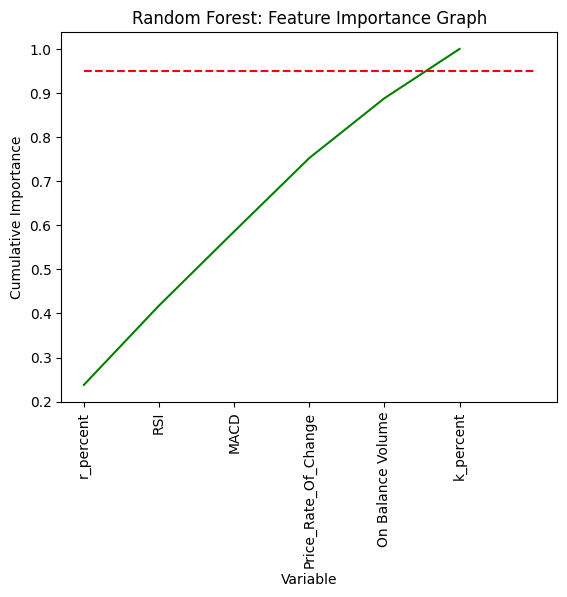

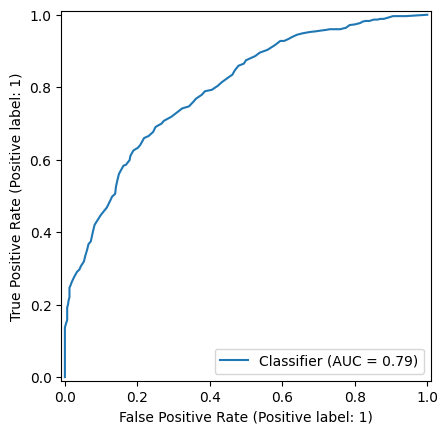

In [19]:

# store the values in a list to plot.
x_values = list(range(len(rf_regressor.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')
rfc_disp = RocCurveDisplay.from_predictions( y_test,predictions)
plt.show()


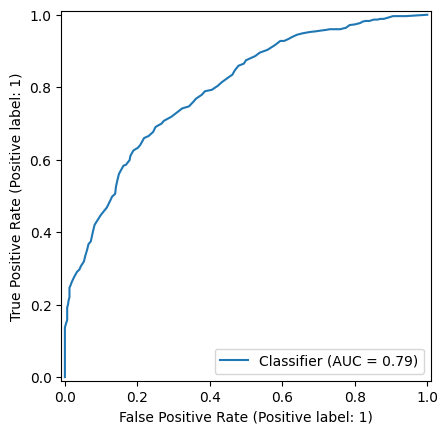

In [21]:
rfc_disp = RocCurveDisplay.from_predictions(y_test,predictions)
plt.show()

In [23]:
#create a dataframe to show the actual and predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(df)

      Actual  Predicted
1052     1.0      -0.20
2990     1.0       0.82
1788     1.0      -0.28
764     -1.0      -0.24
3247    -1.0      -0.54
...      ...        ...
457     -1.0       0.66
4375     1.0      -0.08
2940    -1.0      -1.00
3285    -1.0      -0.06
4890    -1.0      -0.48

[1002 rows x 2 columns]


In [24]:
# Define the hyperparameter grid
n_estimators = list(range(200, 2000, 200))
max_features = ['auto', 'sqrt', None, 'log2']
max_depth = list(range(10, 110, 10))
max_depth.append(None)
min_samples_split = [2, 5, 10, 20, 30, 40]
min_samples_leaf = [1, 2, 7, 12, 14, 16, 20]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Initialize the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search CV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Best parameters from the random search
best_params = rf_random.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf = rf_random.best_estimator_

# Make predictions on the testing set
predictions = best_rf.predict(X_test)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=16, min_samples_split=40, n_estimators=1600; total time=   7.1s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=  12.2s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=  12.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/

Best Parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 20, 'bootstrap': True}


accuracy:  41.25874125874126 %

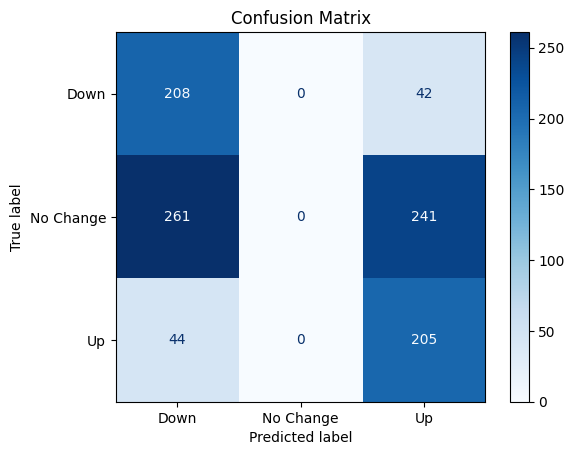

In [35]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Determine actual and predicted directions
actual_directions = np.sign(y_test.values[1:] - y_test.values[:-1])
predicted_directions = np.sign(predictions[1:] - predictions[:-1])

# Ensure labels are -1, 0, 1 (for down, no change, up)
actual_directions = np.where(actual_directions > 0, 1, np.where(actual_directions < 0, -1, 0))
predicted_directions = np.where(predicted_directions > 0, 1, np.where(predicted_directions < 0, -1, 0))

# Calculate accuracy
accuracy = accuracy_score(actual_directions, predicted_directions)
print("accuracy: ",accuracy*100,end=" %")

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_directions, predicted_directions, labels=[-1, 0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Down', 'No Change', 'Up'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

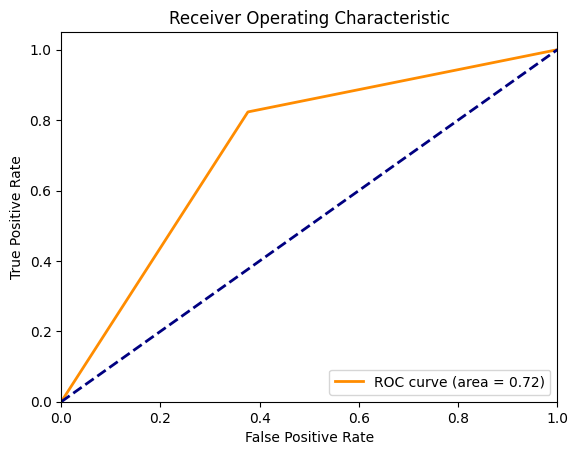

In [28]:
# Convert multi-class to binary classification: Up (1) vs. Not Up (0)
binary_actual = (actual_directions == 1).astype(int)
binary_predicted_proba = (predicted_directions == 1).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(binary_actual, binary_predicted_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [29]:
import joblib

# Save the model
joblib.dump(rf_regressor, '../dump/random_forest_regression_model.pkl')


['../dump/random_forest_regression_model.pkl']